# FFT & CNN-GRU 기반 전력 이상치 탐지

## 라이브러리 임포트 및 시각화 설정

- 데이터 처리, 모델링, 시각화에 필요한 주요 라이브러리를 불러옵니다.

In [1]:
import os
import math
import random
from pathlib import Path
from typing import List, Tuple

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import font_manager as fm
from matplotlib import dates as mdates
from numpy.fft import rfft, rfftfreq

import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader

from sklearn.ensemble import IsolationForest
from sklearn.metrics import classification_report, confusion_matrix

In [2]:
def set_korean_font(preferred=None):
    if preferred is None:
        preferred = ['Noto Sans CJK KR', 'NanumGothic', 'NanumSquare', 'AppleGothic', 'Malgun Gothic', 'DejaVu Sans']
    available = {f.name for f in fm.fontManager.ttflist}
    for font_name in preferred:
        if font_name in available:
            plt.rcParams['font.family'] = font_name
            print(f"한글 폰트 '{font_name}' 적용")
            break
    else:
        print('한글 폰트를 찾지 못해 기본 설정을 유지합니다.')
    plt.rcParams['axes.unicode_minus'] = False

plt.rcParams.update({
    'figure.figsize': (10, 4),
    'axes.grid': True,
    'grid.alpha': 0.25,
    'axes.spines.top': False,
    'axes.spines.right': False,
    'axes.labelsize': 11,
    'axes.titlesize': 13,
    'lines.linewidth': 1.4,
    'legend.frameon': False
})
plt.style.use('seaborn-v0_8-white')
set_korean_font()

한글 폰트 'NanumGothic' 적용


In [3]:
SEED = 2025
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.set_default_dtype(torch.float32)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

## 1. 합성 데이터 생성


- **다중 계절성 반영**: 일간(Daily), 주간(Weekly), 연간(Yearly) 패턴과 기온 변화에 따른 부하 변동을 정교하게 모사합니다.


- **다양한 이상 패턴 주입**: 실제 현장에서 발생할 수 있는 정전, 급증(Surge), 전압 강하(Sag), 노이즈 등 다양한 이상 유형을 무작위로 주입합니다.


- **데이터 저장**: 생성된 더미 데이터는 CSV 파일로 저장되어, 실행 시마다 손쉽게 재현할 수 있습니다.

In [ ]:
DATA_DIR = Path('data')
DATA_DIR.mkdir(parents=True, exist_ok=True)
CSV_PATH = DATA_DIR / 'public_energy_v3.csv'
SAMPLES_PER_DAY = 96  # 15분 간격
FREQ_MINUTES = 15
FORCE_REGENERATE = True  # 필요 시 False로 전환해 재생성 방지
ANOMALY_KEEP_RATIO = 0.55  # 이상 구간 길이를 압축해 탐지율 향상

def generate_public_series(days: int = 92, seed: int = 2025) -> pd.DataFrame:
    rng = np.random.default_rng(seed)
    periods = days * int(1440 / FREQ_MINUTES)
    idx = pd.date_range('2024-01-01', periods=periods, freq=f'{FREQ_MINUTES}min')
    t = np.arange(periods)
    day_frac = (t % SAMPLES_PER_DAY) / SAMPLES_PER_DAY
    weekday = idx.dayofweek.to_numpy()

    base_trend = 1.3 + 0.00045 * t
    daily = 0.32 * np.sin(2 * np.pi * day_frac - 0.3)
    evening_peak = 0.22 * np.sin(4 * np.pi * day_frac + 0.8)
    weekend_offset = np.where(weekday >= 5, -0.28, 0.08)
    weekly = 0.18 * np.sin(2 * np.pi * t / (SAMPLES_PER_DAY * 7) + 0.5)
    biweekly_temp = 0.12 * np.sin(2 * np.pi * t / (SAMPLES_PER_DAY * 14) - 0.7)
    random_weather = 0.07 * rng.standard_normal(periods)
    values = base_trend + daily + evening_peak + weekend_offset + weekly + biweekly_temp + random_weather

    events = [
        {'start_day': 5, 'length': 32, 'kind': 'surge', 'magnitude': 0.9},
        {'start_day': 13, 'length': 48, 'kind': 'sag', 'magnitude': 0.8},
        {'start_day': 20, 'length': 72, 'kind': 'ramp_up', 'magnitude': 0.6},
        {'start_day': 33, 'length': 40, 'kind': 'noisy', 'magnitude': 0.7},
        {'start_day': 46, 'length': 96, 'kind': 'outage', 'magnitude': 1.1},
        {'start_day': 58, 'length': 64, 'kind': 'plateau_high', 'magnitude': 0.5},
        {'start_day': 69, 'length': 56, 'kind': 'brownout', 'magnitude': 0.7},
        {'start_day': 80, 'length': 84, 'kind': 'sawtooth', 'magnitude': 0.6},
    ]

    def day_to_idx(day: int) -> int:
        return int(day * SAMPLES_PER_DAY)

    for event in events:
        start = day_to_idx(event['start_day']) + rng.integers(0, SAMPLES_PER_DAY // 3)
        raw_end = min(start + event['length'], periods)
        raw_length = raw_end - start

        if raw_length <= 0:
            continue

        keep_length = max(1, int(math.ceil(raw_length * ANOMALY_KEEP_RATIO)))
        end = min(start + keep_length, periods)
        seg = slice(start, end)
        length = end - start
        kind = event['kind']
        mag = event['magnitude']
        rel = np.linspace(-1, 1, length)

        if kind == 'surge':
            envelope = np.exp(-0.5 * ((rel) / 0.35) ** 2)
            values[seg] += mag * envelope

        elif kind == 'sag':
            envelope = np.exp(-0.5 * ((rel) / 0.4) ** 2)
            values[seg] -= mag * envelope

        elif kind == 'ramp_up':
            values[seg] += np.linspace(-mag * 0.2, mag, length)
        elif kind == 'noisy':
            jit = rng.normal(0, mag, size=length) * np.sign(np.sin(np.linspace(0, 6 * np.pi, length)))
            values[seg] += jit
        elif kind == 'outage':
            values[seg] = np.maximum(values[seg] - (mag + 0.5), 0.1) + rng.normal(0, 0.03, length)
        elif kind == 'plateau_high':
            plateau = np.percentile(values, 95) + mag
            values[seg] = plateau + rng.normal(0, 0.03, length)
        elif kind == 'brownout':
            values[seg] = np.maximum(values[seg] - mag, 0.2)
        elif kind == 'sawtooth':
            saw = (rel + 1) / 2  # 0~1
            values[seg] += mag * (saw - 0.5)

    spike_indices = rng.choice(periods - 3, size=28, replace=False)
    for idx_spike in spike_indices:
        pulse = rng.uniform(0.4, 0.9)
        values[idx_spike:idx_spike + 3] += np.array([0.0, pulse, -0.6 * pulse])
    values = np.clip(values, 0.05, None)
    df = pd.DataFrame({'ds': idx, 'y': values.astype(np.float32)})
    return df

if FORCE_REGENERATE:
    if CSV_PATH.exists():
        CSV_PATH.unlink()

if FORCE_REGENERATE or not CSV_PATH.exists():
    raw_df = generate_public_series()
    raw_df[['ds', 'y']].to_csv(CSV_PATH, index=False)
    print('합성 데이터셋을 새로 생성하고 저장했습니다:')
else:
    raw_df = pd.read_csv(CSV_PATH, parse_dates=['ds'])
    print('기존 합성 데이터셋을 불러왔습니다:')

raw_sequences = raw_df['y'].to_numpy(dtype=np.float32)[None, :]

print('CSV 경로:', CSV_PATH)
print('샘플 행:')
raw_df.head()

합성 데이터셋을 새로 생성하고 저장했습니다:
CSV 경로: data/public_energy_v3.csv
샘플 행:


,ds,y
0,2024-01-01 00:00:00,1.296755
1,2024-01-01 00:15:00,1.495268
2,2024-01-01 00:30:00,1.494220
3,2024-01-01 00:45:00,1.488340
4,2024-01-01 01:00:00,1.428527


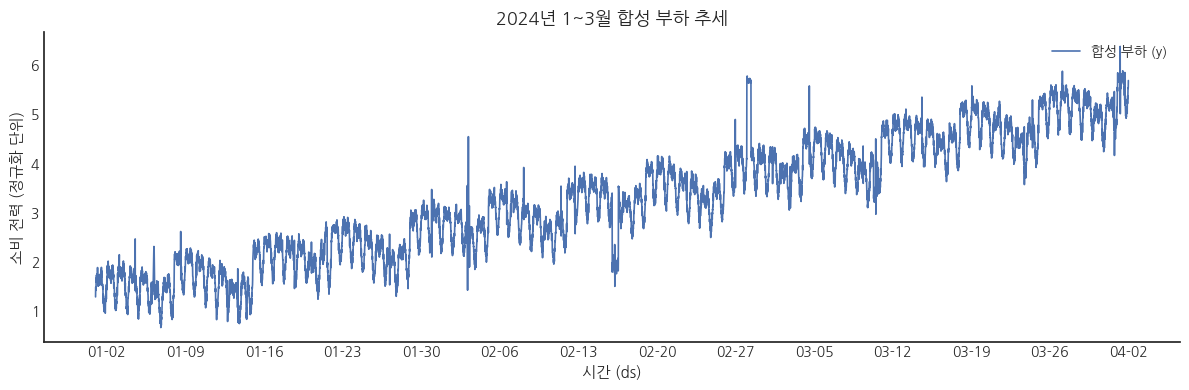

In [ ]:
fig, ax = plt.subplots(figsize=(12, 4))
ax.plot(raw_df['ds'], raw_df['y'], color='#4c72b0', linewidth=1.2, label='합성 부하 (y)')
ax.set_title('2024년 1~3월 합성 부하 추세')
ax.set_xlabel('시간 (ds)')
ax.set_ylabel('소비 전력 (정규화 단위)')
ax.xaxis.set_major_locator(mdates.WeekdayLocator(interval=1))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
ax.tick_params(axis='x', rotation=0)
ax.legend(loc='upper right')
plt.tight_layout()
plt.show()

## 2. 데이터 전처리 및 주기성 분석

- **1차 차분(Differencing)**: 시계열의 비정상성(Non-stationarity)을 제거하여 모델 학습을 돕습니다.

- **표준화(Standardization)**: 데이터의 스케일을 조정하여 학습 안정성을 높입니다.

- **FFT 기반 주기 추정**: 고속 푸리에 변환을 통해 데이터의 지배적인 주기를 파악하고, 이를 바탕으로 최적의 윈도우 크기(Window Size)와 스트라이드(Stride)를 자동으로 결정합니다.

In [ ]:
def first_difference(arr: np.ndarray) -> np.ndarray:
    return np.diff(arr, axis=1)

def standardize(arr: np.ndarray) -> np.ndarray:
    mean = arr.mean(axis=1, keepdims=True)
    std = arr.std(axis=1, keepdims=True) + 1e-6
    return (arr - mean) / std
diff_sequences = first_difference(raw_sequences)
standard_sequences = standardize(diff_sequences)
print('차분 시퀀스 형태:', diff_sequences.shape)
print('표준화 시퀀스 평균:', float(standard_sequences.mean()))

차분 시퀀스 형태: (1, 8831)
표준화 시퀀스 평균: -6.1555245345346066e-09


In [7]:
def estimate_period(signal: np.ndarray, samples_per_day: int) -> int:
    spectrum = np.abs(rfft(signal))
    freqs = rfftfreq(signal.size, d=1.0 / samples_per_day)
    if spectrum.size <= 1:
        return signal.size
    idx = spectrum[1:].argmax() + 1
    freq = max(freqs[idx], 1e-6)
    period = int(round(samples_per_day / freq))
    return max(16, min(signal.size, period))

dominant_periods = [estimate_period(seq, SAMPLES_PER_DAY) for seq in standard_sequences]
WINDOW_SIZE = int(np.clip(np.median(dominant_periods), 32, 128))
STRIDE = max(8, WINDOW_SIZE // 4)
print(f'지배 주기 중앙값: {np.median(dominant_periods):.1f}')
print(f'사용 윈도우/스트라이드: {WINDOW_SIZE}/{STRIDE}')

지배 주기 중앙값: 48.0
사용 윈도우/스트라이드: 48/12


## 2-1. 주파수 도메인 분석 시각화

- FFT 분석 결과를 로그 스케일 그래프로 시각화하여, 데이터 내에 존재하는 주요 주기 성분을 직관적으로 확인합니다.

- 상위 5개의 지배적인 주기를 추출하여 표시함으로써, 선택된 윈도우 크기의 타당성을 뒷받침합니다.

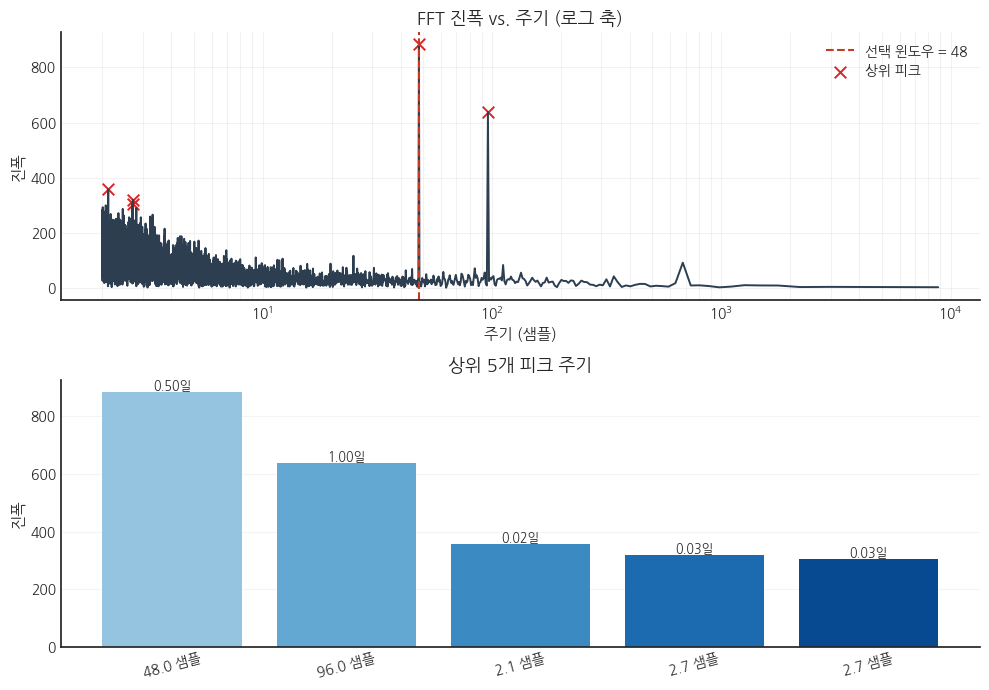

추정된 주요 주기 (샘플): [47.99 95.99  2.12  2.71  2.71]


In [8]:
series_fft = np.abs(rfft(standard_sequences[0]))
freqs = rfftfreq(standard_sequences[0].size, d=1.0 / SAMPLES_PER_DAY)
valid = freqs > 0
periods = SAMPLES_PER_DAY / freqs[valid]
amplitudes = series_fft[valid]

peak_count = 5
peak_idx = np.argpartition(amplitudes, -peak_count)[-peak_count:]
peak_idx = peak_idx[np.argsort(amplitudes[peak_idx])[::-1]]
peak_periods = periods[peak_idx]
peak_amps = amplitudes[peak_idx]

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 7))
ax1.plot(periods, amplitudes, color='#2c3e50')
ax1.set_xscale('log')
ax1.set_title('FFT 진폭 vs. 주기 (로그 축)')
ax1.set_xlabel('주기 (샘플)')
ax1.set_ylabel('진폭')
ax1.axvline(WINDOW_SIZE, color='#c23b22', linestyle='--', linewidth=1.5, label=f'선택 윈도우 = {WINDOW_SIZE}')
ax1.scatter(peak_periods, peak_amps, color='#d62728', marker='x', s=70, label='상위 피크')
ax1.legend(loc='upper right')
ax1.grid(alpha=0.25, which='both')

bars = ax2.bar(range(peak_count), peak_amps, color=plt.cm.Blues(np.linspace(0.4, 0.9, peak_count)))
ax2.set_title('상위 5개 피크 주기')
ax2.set_ylabel('진폭')
ax2.set_xticks(range(peak_count))
ax2.set_xticklabels([f'{p:.1f} 샘플' for p in peak_periods], rotation=15)
for bar, period in zip(bars, peak_periods):
    ax2.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.02, f'{period / SAMPLES_PER_DAY:.2f}일',
             ha='center', va='bottom', fontsize=9)
ax2.grid(axis='y', alpha=0.2)
plt.tight_layout()
plt.show()

print('추정된 주요 주기 (샘플):', np.round(peak_periods, 2))

## 3. 학습 데이터셋 구성




- **슬라이딩 윈도우**: 시계열 데이터를 고정된 길이의 윈도우로 분할합니다.




- **비지도 학습 전제**: 합성 데이터 전체를 정상 패턴으로 간주하고 학습에 사용합니다. 이상 여부는 모델이 산출한 재구성 오차로만 판단합니다.




- **평가 데이터셋**: 동일한 윈도우들을 대상으로 재구성 오차를 측정하여 이상 탐지 점수를 도출합니다.

In [ ]:
def build_windows(signals: np.ndarray, window_size: int, stride: int):
    data, positions = [], []
    for seq_idx, seq in enumerate(signals):
        if seq.size < window_size:
            continue
        for start in range(0, seq.size - window_size + 1, stride):
            end = start + window_size
            data.append(seq[start:end].astype(np.float32))
            positions.append((seq_idx, start))
    if not data:
        raise ValueError('윈도우가 생성되지 않았습니다. 파라미터를 점검하세요.')
    return np.stack(data), positions

all_windows, all_pos = build_windows(standard_sequences, WINDOW_SIZE, STRIDE)
split_ratio = 0.7
split_idx = max(1, int(len(all_windows) * split_ratio))
train_windows = all_windows[:split_idx]
train_pos = all_pos[:split_idx]
eval_windows = all_windows
eval_pos = all_pos
print('윈도우 개수(학습/전체):', train_windows.shape[0], eval_windows.shape[0])

윈도우 개수(학습/전체): 512 732


In [ ]:
class WindowDataset(Dataset):
    def __init__(self, windows: np.ndarray, labels: np.ndarray | None = None):
        self.windows = torch.from_numpy(windows).unsqueeze(1)
        if labels is None:
            labels = np.zeros(len(windows), dtype=np.int64)
        self.labels = torch.from_numpy(labels)

    def __len__(self):
        return self.windows.size(0)
    def __getitem__(self, idx):
        return self.windows[idx], self.labels[idx]

BATCH_SIZE = 64
train_dataset = WindowDataset(train_windows)
eval_dataset = WindowDataset(eval_windows)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
train_eval_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=False)
eval_loader = DataLoader(eval_dataset, batch_size=BATCH_SIZE, shuffle=False)
len(train_dataset), len(eval_dataset)

(512, 732)

## 4. CNN-GRU 하이브리드 모델 설계

- **CNN 인코더**: 1D 합성곱 층을 통해 시계열의 국소적인 특징(Local Features)을 효과적으로 추출합니다.

- **GRU 인코더/디코더**: 시계열의 시간적 의존성(Temporal Dependencies)을 학습하여 데이터의 전반적인 흐름을 파악합니다.

- **구조**: `CNN Encoder` -> `GRU Encoder` -> `Latent Vector` -> `GRU Decoder` -> `CNN Decoder` 구조를 통해 입력 데이터를 압축하고 복원합니다.

In [11]:
class CNNGRUAutoencoder(nn.Module):
    def __init__(self, channels: int = 1, cnn_latent: int = 32, gru_hidden: int = 64, latent_dim: int = 24):
        super().__init__()
        self.encoder_cnn = nn.Sequential(
            nn.Conv1d(channels, 16, kernel_size=3, padding=1),
            nn.GELU(),
            nn.Conv1d(16, cnn_latent, kernel_size=3, padding=1),
            nn.GELU()
        )
        self.gru_encoder = nn.GRU(input_size=cnn_latent, hidden_size=gru_hidden, batch_first=True)
        self.latent_proj = nn.Linear(gru_hidden, latent_dim)
        self.gru_decoder = nn.GRU(input_size=latent_dim, hidden_size=cnn_latent, batch_first=True)
        self.decoder_cnn = nn.Sequential(
            nn.Conv1d(cnn_latent, 16, kernel_size=3, padding=1),
            nn.GELU(),
            nn.Conv1d(16, channels, kernel_size=3, padding=1)
        )

    def forward(self, x):
        encoded = self.encoder_cnn(x)
        seq = encoded.permute(0, 2, 1)
        _, h_n = self.gru_encoder(seq)
        latent = self.latent_proj(h_n[-1])
        latent_seq = latent.unsqueeze(1).repeat(1, seq.size(1), 1)
        decoded_seq, _ = self.gru_decoder(latent_seq)
        decoded_seq = decoded_seq.permute(0, 2, 1)
        reconstruction = self.decoder_cnn(decoded_seq)
        return reconstruction, latent

model = CNNGRUAutoencoder().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.MSELoss()

## 5. 모델 학습 (정상 패턴 습득)

- 정상 윈도우 데이터만을 사용하여 모델을 학습시킵니다.

- 모델은 정상 패턴을 복원하는 방법을 학습하게 되며, 추후 이상 패턴이 입력되었을 때 복원 오차가 커지는 원리를 이용합니다.

In [12]:
EPOCHS = 20
history = []
model.train()
for epoch in range(1, EPOCHS + 1):
    running = 0.0
    for batch, _ in train_loader:
        batch = batch.to(device)
        optimizer.zero_grad(set_to_none=True)
        recon, _ = model(batch)
        loss = criterion(recon, batch)
        loss.backward()
        optimizer.step()
        running += loss.item() * batch.size(0)
    epoch_loss = running / len(train_loader.dataset)
    history.append(epoch_loss)
    if epoch % 5 == 0 or epoch == 1:
        print(f'Epoch {epoch:02d} | Loss {epoch_loss:.6f}')
history[-5:]

Epoch 01 | Loss 1.062136
Epoch 05 | Loss 1.061083
Epoch 10 | Loss 1.047705
Epoch 15 | Loss 1.035806
Epoch 20 | Loss 1.026787
Epoch 20 | Loss 1.026787


[1.033928543329239,
 1.0314933508634567,
 1.029303602874279,
 1.027909405529499,
 1.026786632835865]

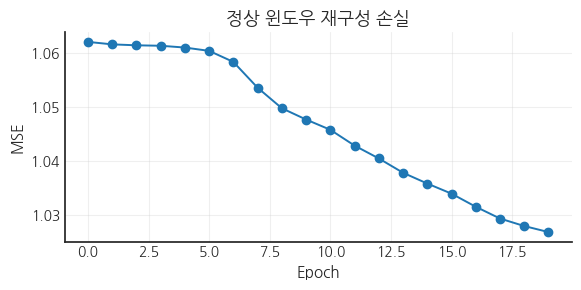

In [13]:
plt.figure(figsize=(6, 3))
plt.plot(history, marker='o')
plt.title('정상 윈도우 재구성 손실')
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

## 6. 학습 결과 및 설정 저장

- 학습된 모델의 가중치(Weights)와 윈도우 크기, 시드값 등 핵심 설정 정보를 파일로 저장합니다.

- 이는 추후 모델을 재사용하거나 배포할 때 동일한 환경을 구성하기 위함입니다.

In [14]:
artifact_dir = 'artifacts_v3'
os.makedirs(artifact_dir, exist_ok=True)
artifact_path = os.path.join(artifact_dir, 'cnn_gru_dummy_v3.pth')
torch.save({
    'model_state': model.state_dict(),
    'config': {
        'window_size': WINDOW_SIZE,
        'stride': STRIDE,
        'seed': SEED,
        'samples_per_day': SAMPLES_PER_DAY,
        'version': 'public-v3'
    }
}, artifact_path)
print('모델 저장 경로:', artifact_path)

모델 저장 경로: artifacts_v3/cnn_gru_dummy_v3.pth


## 7. 재구성 오차 계산 (DTW & MSE)

- 학습된 모델을 사용하여 평가 데이터셋의 복원 결과를 생성합니다.

- **DTW (Dynamic Time Warping)**: 시계열의 시간 축 뒤틀림을 고려한 거리 척도로, 단순 유클리드 거리보다 패턴의 유사성을 더 정확하게 측정합니다.

- **MSE (Mean Squared Error)**: 값의 절대적인 차이를 측정하는 보조 지표로 사용합니다.

In [15]:
def dtw_distance(x: np.ndarray, y: np.ndarray) -> float:
    n, m = x.size, y.size
    cost = np.full((n + 1, m + 1), np.inf, dtype=np.float32)
    cost[0, 0] = 0.0
    for i in range(1, n + 1):
        for j in range(1, m + 1):
            diff = abs(x[i - 1] - y[j - 1])
            cost[i, j] = diff + min(cost[i - 1, j], cost[i, j - 1], cost[i - 1, j - 1])
    return float(cost[n, m] / (n + m))

def compute_scores(model: nn.Module, loader: DataLoader):
    model.eval()
    dtw_scores, mse_scores = [], []
    with torch.no_grad():
        for batch, _ in loader:
            batch = batch.to(device)
            recon, _ = model(batch)
            originals = batch.cpu().numpy()
            reconstructions = recon.cpu().numpy()
            for original, reconstruction in zip(originals, reconstructions):
                x = original.squeeze(0)
                y = reconstruction.squeeze(0)
                dtw_scores.append(dtw_distance(x, y))
                mse_scores.append(float(np.mean((x - y) ** 2)))
    return np.array(dtw_scores), np.array(mse_scores)

train_dtw, train_mse = compute_scores(model, train_eval_loader)
eval_dtw, eval_mse = compute_scores(model, eval_loader)
print('Train/Eval DTW 평균:', float(train_dtw.mean()), float(eval_dtw.mean()))

Train/Eval DTW 평균: 0.30689698044443503 0.30427490101485954


## 8. Isolation Forest 기반 이상치 판정




- DTW와 MSE 점수를 특징(Feature)으로 사용하여 Isolation Forest 모델을 학습시킵니다.




- **Isolation Forest**: 데이터의 분포를 가정하지 않고, 고립되기 쉬운 관측치를 이상치로 식별하는 비지도 학습 알고리즘입니다.




- 라벨 없이 모델이 생성한 재구성 오차만을 활용하여 탐지 점수를 산출합니다.

In [ ]:
feature_stack = np.stack([train_dtw, train_mse], axis=1)
feature_mean = feature_stack.mean(axis=0)
feature_std = feature_stack.std(axis=0) + 1e-6
train_features = (feature_stack - feature_mean) / feature_std
eval_features_raw = np.stack([eval_dtw, eval_mse], axis=1)
eval_features = (eval_features_raw - feature_mean) / feature_std
contamination = 0.18  # 탐지 민감도를 위한 휴리스틱 값

iso = IsolationForest(contamination=contamination, random_state=SEED)
iso.fit(train_features)
eval_pred = (iso.predict(eval_features) == -1).astype(int)
decision_scores = iso.decision_function(eval_features)

results_df = pd.DataFrame({
    'sequence_index': [idx for idx, _ in eval_pos],
    'window_start': [start for _, start in eval_pos],
    'dtw_score': eval_dtw,
    'mse_score': eval_mse,
    'pred_label': eval_pred,
    'decision_score': decision_scores
})

print(f'IsolationForest contamination 설정값: {contamination:.3f}')
print(f'평균 DTW (학습/전체): {train_dtw.mean():.4f} / {eval_dtw.mean():.4f}')
print(f'탐지된 윈도우 비율: {eval_pred.mean():.3f}')
results_df.head()

IsolationForest contamination 설정값: 0.180
평균 DTW (학습/전체): 0.3069 / 0.3043
탐지된 윈도우 비율: 0.172


,sequence_index,window_start,dtw_score,mse_score,pred_label,decision_score
0,0,0,0.303283,0.689430,0,0.104032
1,0,12,0.329665,0.758519,0,0.077935
2,0,24,0.301128,0.651159,0,0.106450
3,0,36,0.318730,0.669607,0,0.105213
4,0,48,0.306128,0.649145,0,0.110206


## 9. 탐지 결과 시각화 및 분석




- **최고 이상 구간**: DTW 오차가 가장 큰 구간을 시각화하여 모델이 어떤 패턴을 가장 비정상으로 판단했는지 확인합니다.




- **오차 분포**: 모델이 정상/이상으로 추정한 구간별 DTW 점수 분포를 비교하여 분리도를 평가합니다.

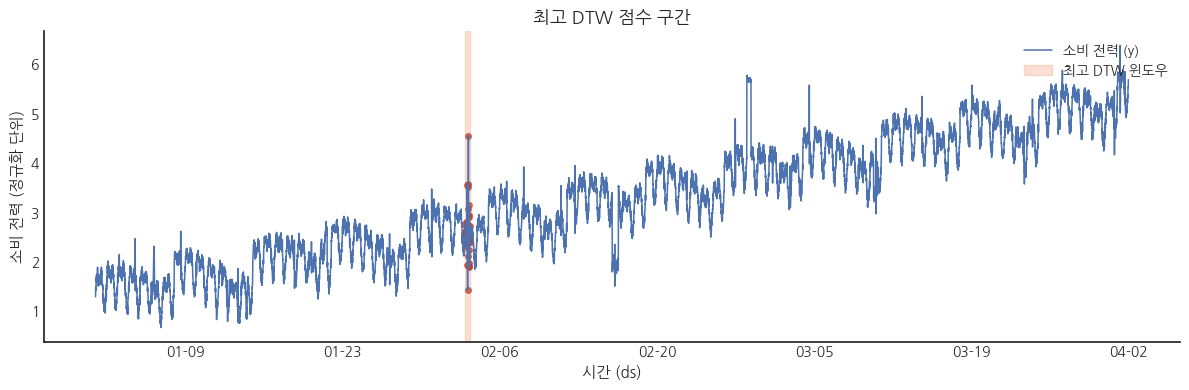

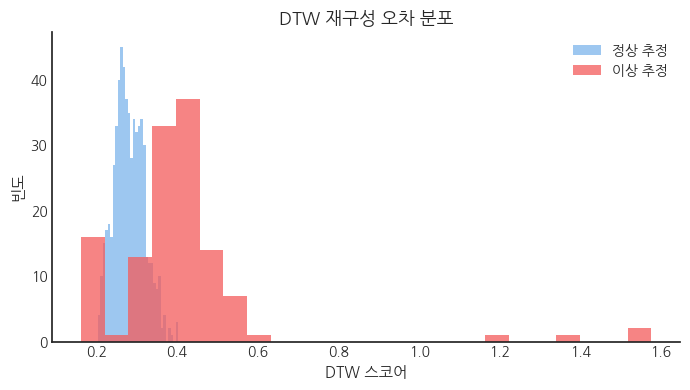

In [ ]:
top_anomaly = results_df.sort_values('dtw_score', ascending=False).iloc[0]
win_start = int(top_anomaly['window_start']) + 1  # 차분 보정
win_end = win_start + WINDOW_SIZE
series_df = raw_df.reset_index(drop=True)
highlight = series_df.iloc[win_start:win_end]

fig, ax = plt.subplots(figsize=(12, 4))
ax.plot(series_df['ds'], series_df['y'], color='#4c72b0', linewidth=1.1, label='소비 전력 (y)')
ax.axvspan(highlight['ds'].iat[0], highlight['ds'].iat[-1], color='#f4a582', alpha=0.35,
           label='최고 DTW 윈도우')
ax.scatter(highlight['ds'], highlight['y'], color='#c23b22', s=16, alpha=0.7)
ax.set_title('최고 DTW 점수 구간')
ax.set_xlabel('시간 (ds)')
ax.set_ylabel('소비 전력 (정규화 단위)')
ax.xaxis.set_major_locator(mdates.WeekdayLocator(interval=2))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
ax.legend(loc='upper right')
plt.tight_layout()
plt.show()

fig, ax = plt.subplots(figsize=(7, 4))
pred_mask = results_df['pred_label'] == 1
ax.hist(results_df.loc[~pred_mask, 'dtw_score'], bins=32, alpha=0.75, label='정상 추정', color='#7cb5ec')
ax.hist(results_df.loc[pred_mask, 'dtw_score'], bins=24, alpha=0.75, label='이상 추정', color='#f45b5b')
ax.set_title('DTW 재구성 오차 분포')
ax.set_xlabel('DTW 스코어')
ax.set_ylabel('빈도')
ax.legend()
plt.tight_layout()
plt.show()

## 9-1. 전체 시계열 탐지 현황




- 전체 기간에 대한 DTW 점수와 Isolation Forest의 판정 결과를 시각화합니다.




- 라벨 없이 모델이 탐지한 구간만 표시하여, 비지도 탐지 흐름을 확인합니다.

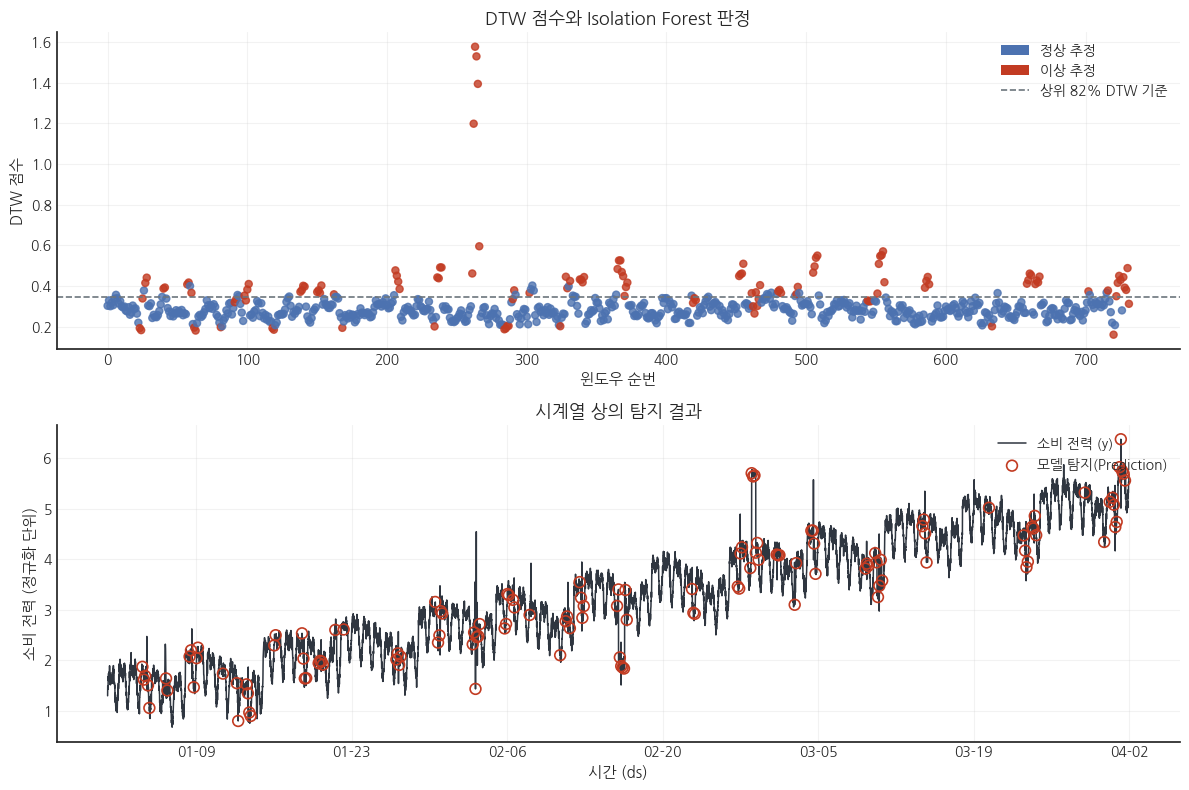

Isolation Forest 탐지 포인트: 126


In [ ]:
from matplotlib.patches import Patch
window_order = np.arange(len(results_df))
pred_colors = np.where(results_df['pred_label'] == 1, '#c23b22', '#4c72b0')
dtw_threshold = np.percentile(train_dtw, 100 * (1 - iso.contamination))
fig, axes = plt.subplots(2, 1, figsize=(12, 8))
axes[0].scatter(window_order, results_df['dtw_score'], c=pred_colors, alpha=0.8, s=26)

threshold_line = axes[0].axhline(dtw_threshold, color='#6c757d', linestyle='--', linewidth=1.2,
                                  label=f'상위 {(1 - iso.contamination) * 100:.0f}% DTW 기준')

axes[0].set_title('DTW 점수와 Isolation Forest 판정')
axes[0].set_xlabel('윈도우 순번')
axes[0].set_ylabel('DTW 점수')
axes[0].legend(handles=[Patch(facecolor='#4c72b0', label='정상 추정'),
                        Patch(facecolor='#c23b22', label='이상 추정'),
                        threshold_line], loc='upper right')
axes[0].grid(alpha=0.25)
series_df = raw_df.reset_index(drop=True)
detected_mask = np.zeros(len(series_df), dtype=bool)
for _, row in results_df[results_df['pred_label'] == 1].iterrows():
    raw_center = int(row['window_start']) + 1 + WINDOW_SIZE // 2
    raw_center = min(raw_center, len(series_df) - 1)
    detected_mask[raw_center] = True

axes[1].plot(series_df['ds'], series_df['y'], color='#2f3640', linewidth=1.1, label='소비 전력 (y)')
if detected_mask.any():
    axes[1].scatter(series_df.loc[detected_mask, 'ds'], series_df.loc[detected_mask, 'y'],
                    facecolor='none', edgecolor='#c23b22', s=60, linewidth=1.2,
                    label='모델 탐지(Prediction)', zorder=4)
axes[1].set_title('시계열 상의 탐지 결과')
axes[1].set_xlabel('시간 (ds)')
axes[1].set_ylabel('소비 전력 (정규화 단위)')
axes[1].xaxis.set_major_locator(mdates.WeekdayLocator(interval=2))
axes[1].xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
axes[1].legend(loc='upper right')
axes[1].grid(alpha=0.25)
plt.tight_layout()
plt.show()

print(f"Isolation Forest 탐지 포인트: {int(detected_mask.sum())}")

## 9-2. 핵심 탐지 구간 상세 분석 (7일 포커스)




- **탐지 밀집 구간 탐색**: 모델이 가장 많이 탐지한 7일간의 데이터를 자동으로 선별하여 확대합니다.




- 라벨 없이 모델이 감지한 패턴만 시각화해, 운영 시 참고할 수 있는 의사결정 힌트를 제공합니다.

탐지 결과가 가장 밀집된 구간을 찾았습니다.


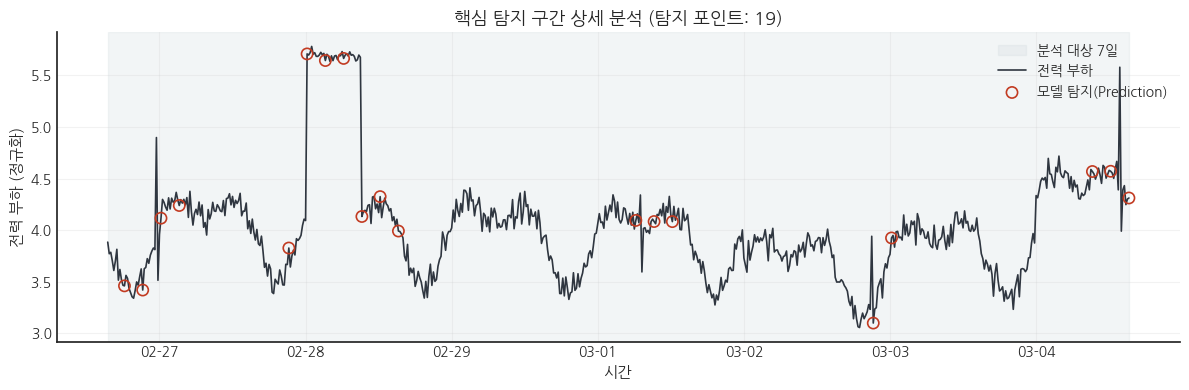

분석 기간: 2024-02-26 15:30:00 ~ 2024-03-04 15:15:00
해당 기간 탐지 포인트: 19


In [ ]:
FOCUS_DAYS = 7
samples_focus = FOCUS_DAYS * SAMPLES_PER_DAY
series_df = raw_df.reset_index(drop=True)
series_len = len(series_df)
detected_mask = np.zeros(series_len, dtype=bool)


for _, row in results_df[results_df['pred_label'] == 1].iterrows():
    raw_center = int(row['window_start']) + 1 + WINDOW_SIZE // 2
    raw_center = min(raw_center, series_len - 1)
    detected_mask[raw_center] = True

if series_len <= samples_focus or detected_mask.sum() == 0:
    focus_start, focus_end = 0, min(series_len, samples_focus)
    if detected_mask.sum() == 0:
        print("탐지된 결과가 없어, 초기 7일 구간을 표시합니다.")

else:
    kernel = np.ones(samples_focus, dtype=int)
    detected_int = detected_mask.astype(int)
    window_counts = np.convolve(detected_int, kernel, mode='valid')
    focus_start = int(window_counts.argmax())
    focus_end = focus_start + samples_focus
    print("탐지 결과가 가장 밀집된 구간을 찾았습니다.")

focus_df = series_df.iloc[focus_start:focus_end].copy()
focus_detected = detected_mask[focus_start:focus_end]

fig, ax = plt.subplots(figsize=(12, 4))
ax.axvspan(focus_df['ds'].iat[0], focus_df['ds'].iat[-1], color='#cfd8dc', alpha=0.25, label='분석 대상 7일')
ax.plot(focus_df['ds'], focus_df['y'], color='#2f3640', linewidth=1.2, label='전력 부하')

if focus_detected.any():
    ax.scatter(focus_df.loc[focus_detected, 'ds'], focus_df.loc[focus_detected, 'y'],
               facecolor='none', edgecolor='#c23b22', s=65, linewidth=1.2,
               label='모델 탐지(Prediction)', zorder=4)

ax.set_title(f'핵심 탐지 구간 상세 분석 (탐지 포인트: {int(focus_detected.sum())})')
ax.set_xlabel('시간')
ax.set_ylabel('전력 부하 (정규화)')
ax.xaxis.set_major_locator(mdates.DayLocator(interval=1))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
ax.legend(loc='upper right')
ax.grid(alpha=0.25)

plt.tight_layout()
plt.show()


print(f"분석 기간: {focus_df['ds'].iat[0]} ~ {focus_df['ds'].iat[-1]}")
print(f"해당 기간 탐지 포인트: {int(focus_detected.sum())}")

## 10. 모델 검증 및 재현성 확인

- 저장된 모델 아티팩트를 다시 로드하여, 동일한 입력에 대해 동일한 DTW 점수가 산출되는지 확인합니다.

- 이는 모델 배포 시 정합성을 보장하기 위한 필수적인 검증 단계입니다.

In [20]:
artifact_loaded = torch.load(artifact_path, map_location=device)
model_reloaded = CNNGRUAutoencoder().to(device)
model_reloaded.load_state_dict(artifact_loaded['model_state'])
model_reloaded.eval()

sample_batch, _ = next(iter(eval_loader))
sample_batch = sample_batch[:4].to(device)
with torch.no_grad():
    sample_recon, _ = model_reloaded(sample_batch)
scores = []
for original, reconstruction in zip(sample_batch.cpu().numpy(), sample_recon.cpu().numpy()):
    scores.append(dtw_distance(original.squeeze(0), reconstruction.squeeze(0)))
print('재로딩 후 샘플 DTW 점수:', np.round(scores, 4))
print('저장된 설정:', artifact_loaded['config'])

재로딩 후 샘플 DTW 점수: [0.3033 0.3297 0.3011 0.3187]
저장된 설정: {'window_size': 48, 'stride': 12, 'seed': 2025, 'samples_per_day': 96, 'version': 'public-v3'}
